In [1]:
# Cell 1 — load patient embeddings
import numpy as np
from pathlib import Path
PROJECT = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease")
DATA = PROJECT / "data" / "processed" / "patient_embeddings.npz"
print("Loading:", DATA)
d = np.load(DATA, allow_pickle=True)
X = d['X']; y = d['y']; ids = d['ids']
print("X shape:", X.shape, "y shape:", y.shape, "n_ids:", len(ids))


Loading: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\patient_embeddings.npz
X shape: (75, 96) y shape: (75,) n_ids: 75


In [2]:
# Cell 2 — splits (stratified)
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    X, y, ids, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp, y_temp, ids_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train positive / negative:", sum(y_train), len(y_train)-sum(y_train))


Train: (52, 96) Val: (11, 96) Test: (12, 96)
Train positive / negative: 26 26


In [3]:
# Cell 3 — build and train patient-level classifier
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

inp = layers.Input(shape=(X.shape[1],), name='inp')
x = layers.Dense(128, activation='relu')(inp)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation='sigmoid', name='out')(x)
clf = models.Model(inp, out)
clf.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

es = callbacks.EarlyStopping(monitor='val_auc', patience=12, mode='max', restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=6, mode='max', min_lr=1e-6)

history = clf.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=200, batch_size=8, callbacks=[es, rlr], verbose=2)

# save model
out_model = PROJECT / "data" / "processed" / "patient_level_clf.h5"
clf.save(out_model)
print("Saved patient-level classifier to:", out_model)


Epoch 1/200
7/7 - 1s - loss: 0.9334 - accuracy: 0.5192 - auc: 0.4985 - val_loss: 0.7066 - val_accuracy: 0.3636 - val_auc: 0.2000 - lr: 0.0010 - 1s/epoch - 169ms/step
Epoch 2/200
7/7 - 0s - loss: 0.6687 - accuracy: 0.6346 - auc: 0.6797 - val_loss: 0.7133 - val_accuracy: 0.4545 - val_auc: 0.2333 - lr: 0.0010 - 41ms/epoch - 6ms/step
Epoch 3/200
7/7 - 0s - loss: 0.7988 - accuracy: 0.5962 - auc: 0.6161 - val_loss: 0.7172 - val_accuracy: 0.3636 - val_auc: 0.2667 - lr: 0.0010 - 38ms/epoch - 5ms/step
Epoch 4/200
7/7 - 0s - loss: 0.7610 - accuracy: 0.6154 - auc: 0.6494 - val_loss: 0.7134 - val_accuracy: 0.2727 - val_auc: 0.2667 - lr: 0.0010 - 38ms/epoch - 5ms/step
Epoch 5/200
7/7 - 0s - loss: 0.8162 - accuracy: 0.5577 - auc: 0.5947 - val_loss: 0.7132 - val_accuracy: 0.1818 - val_auc: 0.1333 - lr: 0.0010 - 38ms/epoch - 5ms/step
Epoch 6/200
7/7 - 0s - loss: 0.8497 - accuracy: 0.5385 - auc: 0.5377 - val_loss: 0.7130 - val_accuracy: 0.2727 - val_auc: 0.0833 - lr: 0.0010 - 37ms/epoch - 5ms/step
Epoc

In [4]:
# Cell 4 — evaluate and save test predictions
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pandas as pd, numpy as np

preds_prob = clf.predict(X_test).ravel()
preds = (preds_prob >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, preds_prob))
print("\nClassification report:\n", classification_report(y_test, preds))
print("Confusion matrix:\n", confusion_matrix(y_test, preds))

outdf = pd.DataFrame({'id': ids_test, 'y_true': y_test, 'prob': preds_prob, 'pred': preds})
outcsv = PROJECT / "data" / "processed" / "patient_test_predictions.csv"
outdf.to_csv(outcsv, index=False)
print("Saved test predictions to:", outcsv)


1/1 [==============================] - 0s 83ms/step
ROC AUC: 0.6388888888888891

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

Confusion matrix:
 [[4 2]
 [1 5]]
Saved test predictions to: C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\processed\patient_test_predictions.csv


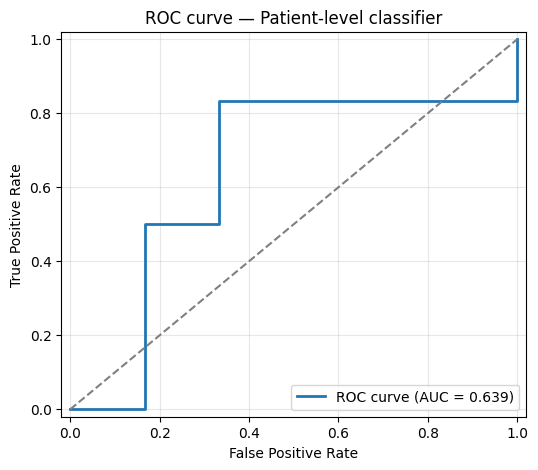

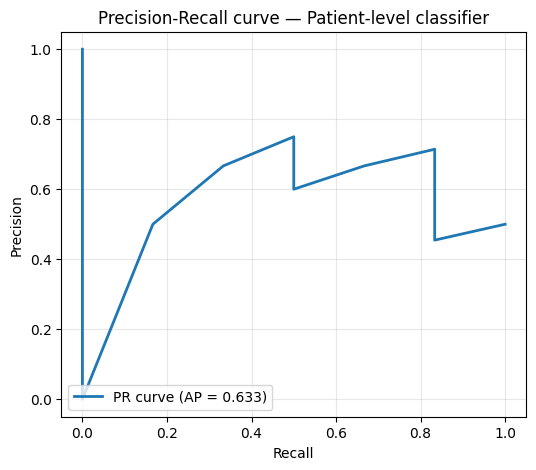

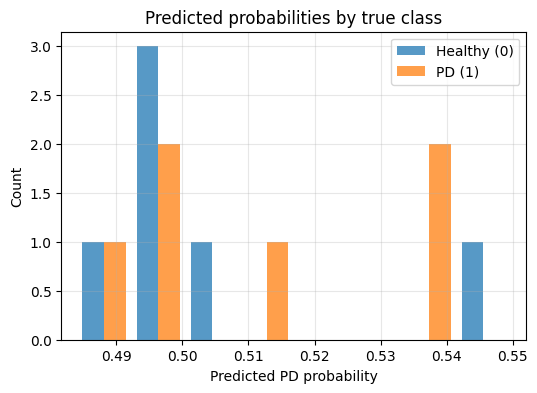

Predictions (head):


,id,y_true,prob,pred
0,94,0,0.549691,1
1,9,1,0.500348,1
2,20,1,0.509943,1
3,60,0,0.498572,0
4,67,0,0.487601,0


In [5]:
# Plot ROC, PR and probability histogram for the saved test predictions
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

PROJECT = Path(r"C:\Users\aibel\Desktop\Heizel Ann Joseph\Parkinsons Disease")
pred_csv = PROJECT / "data" / "processed" / "patient_test_predictions.csv"
df = pd.read_csv(pred_csv)
y_true = df['y_true'].values
y_prob = df['prob'].values
ids = df['id'].values

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([-0.02,1.02]); plt.ylim([-0.02,1.02])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curve — Patient-level classifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label=f'PR curve (AP = {ap:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall curve — Patient-level classifier')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

# Probability histogram by class
plt.figure(figsize=(6,4))
plt.hist([y_prob[y_true==0], y_prob[y_true==1]],
         bins=8, label=['Healthy (0)','PD (1)'], alpha=0.75, stacked=False)
plt.xlabel('Predicted PD probability'); plt.ylabel('Count')
plt.title('Predicted probabilities by true class')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Show the saved CSV head (optional)
print("Predictions (head):")
display(df.head())
